In [1]:
import sys, os; sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__) if '__file__' in globals() else os.getcwd(), '..')))
#import os; os.chdir(os.path.dirname(os.getcwd()))
from utils.model_loader import get_model_fits
import numpy as np
import pandas as pd
import re
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt


/Users/augustarnstad/Documents/source_code/prior_paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
results_dir_relu = "results/classification/single_layer/relu/breastcancer"
results_dir_tanh = "results/classification/single_layer/tanh/breastcancer"
model_names_relu = ["Gaussian", "Regularized Horseshoe", "Dirichlet Horseshoe", "Dirichlet Student T"]#, "Pred CP"]
model_names_tanh = ["Gaussian tanh", "Regularized Horseshoe tanh", "Dirichlet Horseshoe tanh", "Dirichlet Student T tanh"]#, "Pred CP tanh"]



full_config_path = "breast_cancer_N455_p30"

relu_fits = get_model_fits(
    config=full_config_path,
    results_dir=results_dir_relu,
    models=model_names_relu,
    include_prior=False,
)

tanh_fits = get_model_fits(
    config=full_config_path,
    results_dir=results_dir_tanh,
    models=model_names_tanh,
    include_prior=False,
)


16:33:58 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1000 iterations at max treedepth (100.0%)
	Chain 2 had 3 divergent transitions (0.3%)
	Chain 2 had 997 iterations at max treedepth (99.7%)
	Chain 3 had 139 divergent transitions (13.9%)
	Chain 3 had 861 iterations at max treedepth (86.1%)
	Chain 4 had 1 divergent transitions (0.1%)
	Chain 4 had 999 iterations at max treedepth (99.9%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
16:34:01 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1000 iterations at max treedepth (100.0%)
	Chain 2 had 1000 iterations at max treedepth (100.0%)
	Chain 3 had 1000 iterations at max treedepth (100.0%)
	Chain 4 had 1000 iterations at max treedepth (100.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
16:34:05 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 52 divergent transitions (5.2%

In [3]:
from utils.generate_data import load_breast_cancer_data
X_train, X_test, y_train, y_test, *_ = load_breast_cancer_data(
    test_size=0.2, standardize=False, random_state=42
)

In [4]:
import numpy as np

def expected_calibration_error(probs, y_true, n_bins=15, strategy="uniform"):
    """
    Compute ECE (and MCE) using the standard 'confidence' binning approach.

    Parameters
    ----------
    probs : array, shape (n_samples, n_classes) or (n_samples,)
        Predicted probabilities per class (multiclass) or positive-class probs (binary).
    y_true : array, shape (n_samples,)
        True labels as integers in [0, n_classes-1].
    n_bins : int
        Number of bins in [0, 1].
    strategy : {'uniform', 'quantile'}
        'uniform' uses equal-width bins; 'quantile' uses equal-mass bins based on confidences.

    Returns
    -------
    ece : float
        Expected Calibration Error (weighted average |acc - conf|).
    mce : float
        Maximum Calibration Error (max |acc - conf| across bins).
    bin_stats : dict
        Per-bin counts, accuracy, confidence, and edges.
    """
    probs = np.asarray(probs)
    y_true = np.asarray(y_true)

    # Convert to confidences (max class prob) and predicted labels
    if probs.ndim == 1 or (probs.ndim == 2 and probs.shape[1] == 1):
        # Binary: probs is P(y=1). Turn into confidences wrt predicted label.
        p1 = probs.ravel()
        y_hat = (p1 >= 0.5).astype(int)
        conf = np.where(y_hat == 1, p1, 1.0 - p1)
    else:
        y_hat = probs.argmax(axis=1)
        conf = probs.max(axis=1)

    n = len(y_true)
    if strategy == "uniform":
        edges = np.linspace(0.0, 1.0, n_bins + 1)
    elif strategy == "quantile":
        # Use unique quantiles to avoid duplicate edges when many equal confidences
        quantiles = np.linspace(0.0, 1.0, n_bins + 1)
        edges = np.unique(np.quantile(conf, quantiles))
        # Ensure we still cover [0,1]
        edges[0], edges[-1] = 0.0, 1.0
    else:
        raise ValueError("strategy must be 'uniform' or 'quantile'")

    ece = 0.0
    mce = 0.0
    bin_counts, bin_accs, bin_confs = [], [], []

    for b in range(len(edges) - 1):
        lo, hi = edges[b], edges[b + 1]
        # Include left, exclude right except for final bin
        if b < len(edges) - 2:
            mask = (conf >= lo) & (conf < hi)
        else:
            mask = (conf >= lo) & (conf <= hi)

        count = int(mask.sum())
        if count == 0:
            bin_counts.append(0)
            bin_accs.append(np.nan)
            bin_confs.append(np.nan)
            continue

        acc_b = (y_hat[mask] == y_true[mask]).mean()
        conf_b = conf[mask].mean()
        gap = abs(acc_b - conf_b)

        weight = count / n
        ece += weight * gap
        mce = max(mce, gap)

        bin_counts.append(count)
        bin_accs.append(acc_b)
        bin_confs.append(conf_b)

    bin_stats = {
        "counts": np.array(bin_counts),
        "acc": np.array(bin_accs),
        "conf": np.array(bin_confs),
        "edges": np.array(edges),
    }
    return float(ece), float(mce), bin_stats


In [5]:
from sklearn.metrics import accuracy_score, log_loss
from scipy.stats import mode
import pandas as pd
import numpy as np

model_names = list(tanh_fits.keys())
results = []

for model in model_names:
    posterior = tanh_fits[model]['posterior']
    
    # Predicted class labels from posterior samples: majority vote
    pred_samples = posterior.stan_variable("pred_test")                 # shape: [n_samples, n_test]
    majority_preds = mode(pred_samples, axis=0, keepdims=False).mode.flatten()

    # Accuracy
    acc = accuracy_score(y_test, majority_preds)

    # Mean predictive probabilities across posterior samples
    pred_probs = posterior.stan_variable("prob_test")                   # shape: [n_samples, n_test, n_classes]
    mean_probs = pred_probs.mean(axis=0)                                 # shape: [n_test, n_classes]

    # Negative log-likelihood (log loss)
    y_test_adj = y_test - 1  # ensure labels are {0,1} for binary
    nll = log_loss(y_test_adj, mean_probs, labels=[0, 1])

    # ECE / MCE (you can change n_bins or strategy)
    ece, mce, _ = expected_calibration_error(mean_probs, y_test_adj, n_bins=15, strategy="uniform")

    results.append({
        "Model": model,
        "Accuracy": acc,
        "NLL": nll,
        "ECE": ece,
        "MCE": mce
    })

results_df = pd.DataFrame(results)


In [6]:
latex_table = results_df.to_latex(index=False, float_format="%.4f", column_format="lcc", caption="Accuracy and NLL per model.", label="tab:accuracy_nll")
print(latex_table)

\begin{table}
\caption{Accuracy and NLL per model.}
\label{tab:accuracy_nll}
\begin{tabular}{lcc}
\toprule
Model & Accuracy & NLL & ECE & MCE \\
\midrule
Gaussian tanh & 0.9386 & 0.1288 & 0.0267 & 0.7074 \\
Regularized Horseshoe tanh & 0.9649 & 0.1005 & 0.0320 & 0.5003 \\
Dirichlet Horseshoe tanh & 0.9561 & 0.0958 & 0.0330 & 0.5012 \\
Dirichlet Student T tanh & 0.9649 & 0.0975 & 0.0381 & 0.4707 \\
\bottomrule
\end{tabular}
\end{table}



In [7]:
print("Of 114 observations,", np.round(114*results_df['Accuracy'][0], 3), "were classified correctly by the", results_df['Model'][0], "model \n")
print("Of 114 observations,", np.round(114*results_df['Accuracy'][1], 3), "were classified correctly by the", results_df['Model'][1], "model \n")
print("Of 114 observations,", np.round(114*results_df['Accuracy'][2], 3), "were classified correctly by the", results_df['Model'][2], "model \n")
print("Of 114 observations,", np.round(114*results_df['Accuracy'][3], 3), "were classified correctly by the", results_df['Model'][3], "model \n")
#print("Of 114 observations,", np.round(114*results_df['Accuracy'][3], 3), "were classified correctly by the", results_df['Model'][4], "model \n")

Of 114 observations, 107.0 were classified correctly by the Gaussian tanh model 

Of 114 observations, 110.0 were classified correctly by the Regularized Horseshoe tanh model 

Of 114 observations, 109.0 were classified correctly by the Dirichlet Horseshoe tanh model 

Of 114 observations, 110.0 were classified correctly by the Dirichlet Student T tanh model 



In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

X_test_df = pd.DataFrame(X_test)

W_1 = tanh_fits['Gaussian tanh']['posterior'].stan_variable("W_1")[0, :, :]   # (30, 16)
W_2 = tanh_fits['Gaussian tanh']['posterior'].stan_variable("W_L")[0, :, :]   # (16, 2)
b_1 = tanh_fits['Gaussian tanh']['posterior'].stan_variable("hidden_bias")[0, :]  # (16,)
b_2 = tanh_fits['Gaussian tanh']['posterior'].stan_variable("output_bias")[0, :]  # (2,)

# Konverter DataFrame til tensor
X = torch.tensor(X_test_df.to_numpy(), dtype=torch.float32)  # (114, 30)

# Stan-vekter til tensor
W1 = torch.tensor(W_1, dtype=torch.float32)   # (30, 16)
b1 = torch.tensor(b_1.squeeze(), dtype=torch.float32)  # (16,)
W2 = torch.tensor(W_2, dtype=torch.float32)   # (16, 2)
b2 = torch.tensor(b_2, dtype=torch.float32)   # (2,)

# Definer nettverket
class StanNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation=torch.tanh):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.activation = activation

    def forward(self, x):
        h = self.activation(self.linear1(x))
        logits = self.linear2(h)
        return logits  # matcher Stan sin `output`

    def predict_proba(self, x):
        logits = self.forward(x)
        return F.softmax(logits, dim=1)  # matcher Stan sin `prob_test`

    def predict(self, x):
        probs = self.predict_proba(x)
        return torch.argmax(probs, dim=1)  # matcher Stan sin `pred_test`

# Bygg og kopier vektene
model = StanNNClassifier(input_dim=30, hidden_dim=16, output_dim=2, activation=torch.tanh)
with torch.no_grad():
    model.linear1.weight.copy_(W1.T)   # (16, 30)
    model.linear1.bias.copy_(b1)       # (16,)
    model.linear2.weight.copy_(W2.T)   # (2, 16)
    model.linear2.bias.copy_(b2)       # (2,)

# === Test forward ===
logits = model(X)                # (114, 2), Stan: `output_test`
probs = model.predict_proba(X)   # (114, 2), Stan: `prob_test`
preds = model.predict(X)         # (114,),   Stan: `pred_test`

#print("logits shape:", logits.shape)
#print("probs shape :", probs)
#print("preds shape :", preds)


In [9]:
stan_probs = tanh_fits['Gaussian tanh']['posterior'].stan_variable("prob_test")[0, :, :]
stan_probs_torch = torch.tensor(stan_probs, dtype=torch.float32)

print("Max diff:", (probs - stan_probs_torch).abs().max().item())


Max diff: 5.626678466796875e-05


In [13]:
from collections import defaultdict
import pandas as pd
import torch.nn.functional as F
from utils.robust_utils import estimate_robustness_over_test_set
import torch
# === Settings ===
epsilons = [0.01, 0.05, 0.1, 0.25]
#epsilons = [0.1, 0.5, 1.0, 2.5]
scales = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0]
sample_indices = range(0, 4000, 800)
input_dim = X_test.shape[1]
hidden_dim = 16
output_dim = 2
p_norm = 2

# === Subset test set ===
X_test_df = pd.DataFrame(X_test)
y_test_s = pd.Series(y_test) - 1  # Ensure labels in {0,1}
test_subset = X_test_df.sample(frac=1.0, random_state=42)
subset_indices = test_subset.index
y_subset = y_test_s.loc[subset_indices]

# === Run robustness for each model ===
all_results = []

for model_name, fit_entry in tanh_fits.items():
    for epsilon in epsilons:
        for scale in scales:
            delta = scale * epsilon

            df_result = estimate_robustness_over_test_set(
                x_test=test_subset,
                y_test=y_subset,
                fits_dict={model_name: fit_entry},  # Wrap as dict
                input_dim=input_dim,
                hidden_dim=hidden_dim,
                output_dim=output_dim,
                sample_indices=sample_indices,
                epsilon=epsilon,
                delta=delta,
                p_norm=p_norm,
                activation=torch.tanh
            )

            df_result["epsilon"] = epsilon
            df_result["delta"] = delta
            df_result["scale"] = round(scale, 2)
            df_result["model"] = model_name
            all_results.append(df_result.copy())

# === Combine results ===
df_robust = pd.concat(all_results, ignore_index=True)

# === Unpack 'robustness' dictionary column into separate columns ===
df_flat = pd.concat(
    [df_robust.drop(columns=["robustness"]),
     df_robust["robustness"].apply(pd.Series)],
    axis=1
)

# === Add derived columns ===
df_flat["1-p1"] = (1.0 - df_flat["p1"]).round(5)
df_flat["1-p2"] = (1.0 - df_flat["p2"]).round(5)

# Resulting DataFrame: df_flat


Test samples: 100%|██████████| 114/114 [00:00<00:00, 605.27it/s]


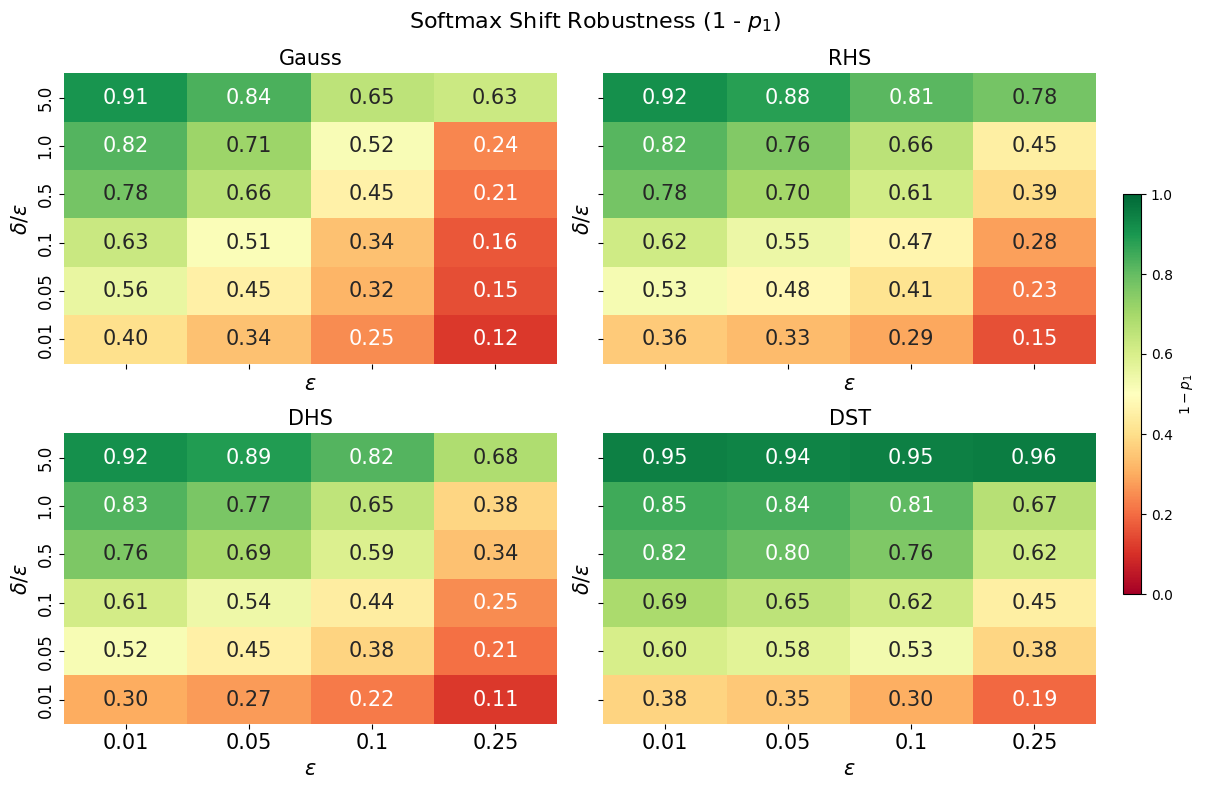

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure model name consistency and ordering
model_order = ["Gaussian tanh", "Regularized Horseshoe tanh", "Dirichlet Horseshoe tanh", "Dirichlet Student T tanh"]#, "Pred CP tanh"]
#model_order = ["Gaussian", "Regularized Horseshoe", "Dirichlet Horseshoe", "Dirichlet Student T"]
#Ns = sorted(df_flat["N"].unique())

# Global color scale (consistent across all plots)
vmin = df_flat["1-p1"].min()
vmax = df_flat["1-p1"].max()

short_names = {
    "Gaussian": "Gauss",
    "Regularized Horseshoe": "RHS",
    "Dirichlet Horseshoe": "DHS",
    "Dirichlet Student T": "DST",
    #"Pred CP": "PCP"
}

short_names = {
    "Gaussian tanh": "Gauss",
    "Regularized Horseshoe tanh": "RHS",
    "Dirichlet Horseshoe tanh": "DHS",
    "Dirichlet Student T tanh": "DST",
    #"Pred CP tanh": "PCP"
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True, sharey=True)

for j, model in enumerate(model_order):
    row, col = divmod(j, 2)
    ax = axes[row, col]
    df_model = df_flat[df_flat["model"] == model]

    # Use pivot_table to handle duplicates
    heatmap_df = df_model.pivot_table(
        index="scale", columns="epsilon", values="1-p1", aggfunc="mean"
    )

    sns.heatmap(
        heatmap_df.sort_index(ascending=False),
        annot=True, fmt=".2f", cmap="RdYlGn", ax=ax,
        cbar=False, vmin=vmin, vmax=vmax, annot_kws={"fontsize":15}
    )

    #ax.set_title(model, fontsize=13)
    ax.set_title(short_names[model], fontsize=15)
    ax.set_xlabel(r"$\varepsilon$", fontsize=15)
    ax.set_ylabel(r"$\delta / \varepsilon$", fontsize=15)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=12)

# Adjust layout to leave space for colorbar
plt.tight_layout(rect=[0, 0, 0.93, 0.95])

# Add colorbar on the right
cbar_ax = fig.add_axes([0.94, 0.25, 0.015, 0.5])  # [left, bottom, width, height]
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax, label='$1 - p_1$')

fig.suptitle(f"Softmax Shift Robustness (1 - $p_1$)", fontsize=16)
plt.savefig("figures_for_use_in_paper/breast_cancer_p1_tanh.pdf", bbox_inches="tight")
plt.show()


In [ ]:
import pandas as pd

# assuming df is your big dataframe
summary = (
    df_flat.groupby("model")["1-p2"]
      .agg(["mean", "std", "min", "max"])
      .reset_index()
      .round(3)
)

print(summary)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure correct model order for consistency
model_order = ["Gaussian", "Regularized Horseshoe", "Dirichlet Horseshoe", "Dirichlet Student T"]#, "Pred CP"]
palette = sns.color_palette("Set2", n_colors=4)

# # Optional: choose one N (or loop if needed)
# N_select = 100
# df_plot = df_flat[df_flat["N"] == N_select]

plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_flat,
    x="epsilon",
    y="1-p2",
    hue="model",
    hue_order=model_order,
    palette=palette,
    cut=0,
    inner="quartile",
    linewidth=1
)

plt.title(f"Label Invariance Probability ($1 - p_2$) across models")
plt.xlabel(r"Adversarial strength $\varepsilon$")
plt.ylabel(r"$1-p_2$")
plt.ylim(0, 1)
plt.legend(title="Model", bbox_to_anchor=(0.02, 0.05))
plt.tight_layout()
plt.grid(True, axis="y")
plt.show()

In [14]:
model_names = ["Gaussian", "Regularized Horseshoe", "Dirichlet Horseshoe", "Dirichlet Student T"]#, "Pred CP"]
entropy_data = {}  # store outputs

for model in model_names:
    probs = relu_fits[model]["posterior"].stan_variable("prob_test")  # shape: (S, N_test, 2)

    mean_probs = np.mean(probs, axis=0)
    predictive_entropy = -np.sum(mean_probs * np.log(mean_probs + 1e-12), axis=1)

    sample_entropies = -np.sum(probs * np.log(probs + 1e-12), axis=2)
    expected_entropy = np.mean(sample_entropies, axis=0)

    mutual_information = predictive_entropy - expected_entropy

    y_pred = np.argmax(mean_probs, axis=1) + 1  # add 1 only if y_test is 1/2
    correct = (y_pred == y_test)

    # Store everything
    entropy_data[model] = {
        "entropy": predictive_entropy,
        "mutual_info": mutual_information,
        "correct": correct
    }


In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(14, 12))
axs = axs.flatten()

for i, model in enumerate(model_names):
    ax = axs[i]
    entropy = entropy_data[model]["entropy"]
    mi = entropy_data[model]["mutual_info"]
    correct = entropy_data[model]["correct"]

    ax.scatter(entropy[correct], mi[correct], color='green', alpha=0.5, label='Correct')
    ax.scatter(entropy[~correct], mi[~correct], color='red', alpha=0.5, label='Incorrect')

    ax.set_title(model)
    ax.set_xlabel("Predictive Entropy")
    ax.set_ylabel("Mutual Information")
    ax.grid(True)

# Legend only once
axs[0].legend()
plt.suptitle("Mutual Information vs Entropy Colored by Prediction Correctness", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
for model in model_names:
    correct = entropy_data[model]["correct"]
    acc = np.mean(correct)
    avg_entropy = np.mean(entropy_data[model]["entropy"])
    avg_mi = np.mean(entropy_data[model]["mutual_info"])
    print(f"{model}: Accuracy={acc:.3f}, Avg Entropy={avg_entropy:.3f}, Avg MI={avg_mi:.3f}")


In [16]:
model_names = ["Gaussian tanh", "Regularized Horseshoe tanh", "Dirichlet Horseshoe tanh", "Dirichlet Student T tanh"]
entropy_data = {}  # store outputs

for model in model_names:
    probs = tanh_fits[model]["posterior"].stan_variable("prob_test")  # shape: (S, N_test, 2)

    mean_probs = np.mean(probs, axis=0)
    predictive_entropy = -np.sum(mean_probs * np.log(mean_probs + 1e-12), axis=1)

    sample_entropies = -np.sum(probs * np.log(probs + 1e-12), axis=2)
    expected_entropy = np.mean(sample_entropies, axis=0)

    mutual_information = predictive_entropy - expected_entropy

    y_pred = np.argmax(mean_probs, axis=1) + 1  # add 1 only if y_test is 1/2
    correct = (y_pred == y_test)

    # Store everything
    entropy_data[model] = {
        "entropy": predictive_entropy,
        "mutual_info": mutual_information,
        "correct": correct
    }


In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(14, 12))
axs = axs.flatten()

for i, model in enumerate(model_names):
    ax = axs[i]
    entropy = entropy_data[model]["entropy"]
    mi = entropy_data[model]["mutual_info"]
    correct = entropy_data[model]["correct"]

    ax.scatter(entropy[correct], mi[correct], color='green', alpha=0.5, label='Correct')
    ax.scatter(entropy[~correct], mi[~correct], color='red', alpha=0.5, label='Incorrect')

    ax.set_title(model)
    ax.set_xlabel("Predictive Entropy")
    ax.set_ylabel("Mutual Information")
    ax.grid(True)

# Legend only once
axs[0].legend()
plt.suptitle("Mutual Information vs Entropy Colored by Prediction Correctness", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
for model in model_names:
    correct = entropy_data[model]["correct"]
    acc = np.mean(correct)
    avg_entropy = np.mean(entropy_data[model]["entropy"])
    avg_mi = np.mean(entropy_data[model]["mutual_info"])
    print(f"{model}: Accuracy={acc:.3f}, Avg Entropy={avg_entropy:.3f}, Avg MI={avg_mi:.3f}")


In [ ]:
import seaborn as sns
import pandas as pd

# Create a DataFrame first
df = pd.DataFrame({
    "Entropy": entropy_data["Dirichlet Student T tanh"]["entropy"],
    "MI": entropy_data["Dirichlet Student T tanh"]["mutual_info"],
    "Correct": entropy_data["Dirichlet Student T tanh"]["correct"]
})

# Plot
sns.jointplot(
    data=df,
    x="Entropy",
    y="MI",
    hue="Correct",
    kind="scatter",
    palette={True: "green", False: "red"},
    alpha=0.5,
    marginal_kws=dict(fill=True)
)


## Testing kappa matrix

In [5]:
from utils.generate_data import load_breast_cancer_data
X, X_test, y, y_test, *_ = load_breast_cancer_data(
    test_size=0.2, standardize=False, random_state=42
)

X      = np.asarray(X, dtype=float)
X_test = np.asarray(X_test, dtype=float)

# y often comes as a (n,1) DataFrame/array — flatten to (n,)
y      = np.asarray(y, dtype=float).reshape(-1)
y_test = np.asarray(y_test, dtype=float).reshape(-1)

In [ ]:
import numpy as np
from typing import Tuple, Callable, List

# ============================================================
# Activations
# ============================================================

def get_activation(activation: str = "tanh") -> Tuple[Callable, Callable]:
    if activation == "tanh":
        phi = np.tanh
        def dphi(a): return 1.0 - np.tanh(a)**2
    elif activation == "relu":
        def phi(a): return np.maximum(0.0, a)
        def dphi(a): return (a > 0.0).astype(a.dtype)
    else:
        raise ValueError(f"Unsupported activation: {activation}")
    return phi, dphi

# ============================================================
# Extraction (Gaussian prior, 2 outputs)
# ============================================================

def extract_gaussian_two_output_draws(fit_dict, model_name: str):
    """
    Returns:
      W_all   : (D,H,p)
      b1_all  : (D,H)
      V_all   : (D,H,2)
      b2_all  : (D,2)
      tau_w   : (D,)   (defaults to ones if missing)
      tau_v   : (D,)   (defaults to ones if missing)
      lam_eff : (D,H,p)  (all ones for Gaussian prior)
    """
    post = fit_dict[model_name]['posterior']

    def _stan_var_or_none(name):
        try:
            return np.asarray(post.stan_variable(name))
        except Exception:
            return None

    # --- hidden_bias => define H from this (robust) ---
    b1_raw = _stan_var_or_none("hidden_bias")
    if b1_raw is None:
        raise ValueError("Missing 'hidden_bias' in posterior.")
    b1_all = np.squeeze(b1_raw)  # handles (D,1,H) -> (D,H)
    if b1_all.ndim == 1:
        # (D,) -> treat as (D,1)
        b1_all = b1_all[:, None]
    if b1_all.ndim != 2:
        raise ValueError(f"Unexpected hidden_bias shape after squeeze: {b1_raw.shape} -> {b1_all.shape}")
    D, H_true = b1_all.shape

    # --- W_1 -> coerce to (D,H,p) using H_true ---
    W_1 = _stan_var_or_none("W_1")
    if W_1 is None:
        raise ValueError("Missing 'W_1' in posterior.")
    if W_1.ndim != 3 or W_1.shape[0] != D:
        raise ValueError(f"Unexpected W_1 shape: {W_1.shape}, D={D}")

    if W_1.shape[1] == H_true:
        # (D,H,p)
        W_all = W_1
    elif W_1.shape[2] == H_true:
        # (D,p,H) -> transpose to (D,H,p)
        W_all = np.transpose(W_1, (0, 2, 1))
    else:
        raise ValueError(f"Cannot match H from hidden_bias (H={H_true}) to W_1 shape {W_1.shape}")

    _, H_check, p = W_all.shape
    assert H_check == H_true, "H mismatch after coercion."

    # --- W_L (output weights) -> coerce to (D,H,2) using H_true ---
    W_L = _stan_var_or_none("W_L")
    if W_L is None:
        raise ValueError("Missing 'W_L' in posterior.")
    if W_L.ndim != 3 or W_L.shape[0] != D:
        raise ValueError(f"Unexpected W_L shape: {W_L.shape}, D={D}")

    if W_L.shape[1] == H_true and W_L.shape[2] == 2:
        V_all = W_L
    elif W_L.shape[1] == 2 and W_L.shape[2] == H_true:
        # (D,2,H) -> (D,H,2)
        V_all = np.transpose(W_L, (0, 2, 1))
    else:
        raise ValueError(f"Cannot coerce W_L shape {W_L.shape} to (D,H=~{H_true},2)")

    # --- output_bias -> (D,2) ---
    b2_raw = _stan_var_or_none("output_bias")
    if b2_raw is None:
        raise ValueError("Missing 'output_bias' in posterior.")
    b2_all = np.squeeze(b2_raw)
    if b2_all.ndim == 1:
        b2_all = b2_all[:, None]
    if b2_all.shape != (D, 2):
        raise ValueError(f"Expected output_bias (D,2), got {b2_raw.shape} -> {b2_all.shape}")

    # --- tau_w (global for input weights) ---
    tau = _stan_var_or_none("tau") or _stan_var_or_none("tau_w")
    tau_w = np.ones(D) if tau is None else np.squeeze(tau).reshape(D)

    # --- tau_v (global for output weights); default 1 ---
    tau_v_arr = _stan_var_or_none("tau_v")
    if tau_v_arr is None:
        tau_v = np.ones(D)
    else:
        tau_v = np.squeeze(tau_v_arr)
        if tau_v.ndim == 0:
            tau_v = np.full(D, float(tau_v))
        elif tau_v.ndim == 1 and tau_v.shape[0] == D:
            pass
        elif tau_v.ndim == 2 and tau_v.shape == (D, 2):
            # reduce per draw to a single scalar (RMS across classes)
            tau_v = np.sqrt(np.mean(tau_v**2, axis=1))
        else:
            raise ValueError(f"Unexpected tau_v shape: {tau_v_arr.shape}")

    # Gaussian prior => lambda_eff = ones
    lam_eff = np.ones((D, H_true, p))

    return W_all, b1_all, V_all, b2_all, tau_w, tau_v, lam_eff

# ============================================================
# Linearization: multi-output (C=2)
# ============================================================

def build_hidden_and_jacobian_W_multi(
    X: np.ndarray,          # (n,p)
    W0: np.ndarray,         # (H,p)
    b0: np.ndarray,         # (H,)
    V0: np.ndarray,         # (H,2)
    activation: str = "tanh",
):
    """
    Returns:
      Phi_mat : (n,H)
      JW_list : [ (n,H*p), (n,H*p) ]  (per-class Jacobians)
      Jb1_list: [ (n,H), (n,H) ]      (per-class hidden-bias Jacobians)
      Jb2_vec : (n,)  (df_c/db2_c = 1)
    """
    n, p = X.shape
    H, pW = W0.shape
    assert pW == p
    assert V0.shape == (H, 2), "Assume exactly two outputs."

    phi, dphi = get_activation(activation)
    A = X @ W0.T + b0[None, :]  # (n,H)
    Phi_mat = phi(A)
    dphiA   = dphi(A)

    JW_list: List[np.ndarray] = []
    Jb1_list: List[np.ndarray] = []
    for c in range(2):
        v_c = V0[:, c]  # (H,)
        # Build (n, H*p) Jacobian block for class c
        blocks = []
        for h in range(H):
            block_h = (v_c[h] * dphiA[:, [h]]) * X  # (n,p)
            blocks.append(block_h.reshape(n, p))
        JW_c = np.hstack(blocks)  # (n,H*p)
        JW_list.append(JW_c)

        # Hidden-bias Jacobian for class c: (n,H)
        Jb1_c = dphiA * v_c[None, :]
        Jb1_list.append(Jb1_c)

    Jb2_vec = np.ones(n)  # df_c/db2_c = 1
    return Phi_mat, JW_list, Jb1_list, Jb2_vec

# ============================================================
# Prior blocks and shrinkage operators
# ============================================================

def build_P_from_lambda_tau(lambda_eff: np.ndarray, tau_w: float) -> np.ndarray:
    """
    Gaussian prior -> lambda_eff == ones. We keep the same interface.
    P = diag( 1 / (tau_w^2 * lambda_eff) ). Here lambda_eff ~ 1, so P ~ I / tau_w^2.
    Returns (H*p, H*p) diagonal.
    """
    lam_vec = lambda_eff.reshape(-1).astype(float)
    diagP = 1.0 / ( (tau_w**2) * lam_vec )
    return np.diag(diagP)

def build_Sigma_y_multi(
    Phi_mat: np.ndarray,   # (n,H)
    tau_v: float,          # scalar per draw (already reduced if needed)
    Jb1_list: List[np.ndarray],  # two items, (n,H) each
    Jb2_vec: np.ndarray,   # (n,)
    include_b1: bool = True,
    include_b2: bool = True,
) -> np.ndarray:
    """
    Base covariance for the linearized outputs, aggregated over the two classes.
    No Gaussian noise term (classification).
    Σ_y = (τ_v^2 + τ_v^2) ΦΦ^T + sum_c J_b1,c J_b1,c^T + 2 * 11^T [if include_b2].
    """
    n = Phi_mat.shape[0]
    # Two outputs; sum of tau_v^2 across classes => 2 * tau_v^2 if scalar-per-draw
    tau_v2_sum = 2.0 * float(tau_v)**2
    Sigma_y = tau_v2_sum * (Phi_mat @ Phi_mat.T)  # (n,n)

    if include_b1 and (Jb1_list is not None):
        for Jb1_c in Jb1_list:
            Sigma_y = Sigma_y + Jb1_c @ Jb1_c.T

    if include_b2 and (Jb2_vec is not None):
        Sigma_y = Sigma_y + 2.0 * np.outer(Jb2_vec, Jb2_vec)

    return Sigma_y

def build_S_multi(JW_list: List[np.ndarray], Sigma_y: np.ndarray) -> np.ndarray:
    """
    S = sum_c J_W_c^T Σ_y^{-1} J_W_c  (Hp x Hp)
    """
    S = None
    for JW_c in JW_list:
        X_c = np.linalg.solve(Sigma_y, JW_c)  # (n, Hp)
        S_c = JW_c.T @ X_c
        S = S_c if S is None else (S + S_c)
    return S

def shrinkage_matrix_stable(P: np.ndarray, S: np.ndarray, jitter: float = 0.0) -> np.ndarray:
    """
    R = (P+S)^{-1} P  computed stably via whitening:
    R = P^{1/2} (I + P^{-1/2} S P^{-1/2})^{-1} P^{1/2}, but implemented with solves.
    """
    d = np.diag(P).astype(float)
    eps = 1e-12
    d = np.clip(d, eps, np.finfo(float).max)
    Phalf = np.diag(np.sqrt(d))
    Pinvhalf = np.diag(1.0 / np.sqrt(d))

    M = Pinvhalf @ S @ Pinvhalf
    if jitter > 0:
        M = M + jitter * np.eye(M.shape[0])

    I = np.eye(M.shape[0])
    L = np.linalg.cholesky(I + M)
    Z = np.linalg.solve(L, Phalf)
    W = np.linalg.solve(L.T, Z)
    R = Pinvhalf @ W
    R = 0.5 * (R + R.T)  # symmetrize
    return R

def shrinkage_eigs_and_df(P: np.ndarray, S: np.ndarray):
    """
    In P-whitened coordinates: M = P^{-1/2} S P^{-1/2}, eigenvals mu>=0
    r = 1/(1+mu) in (0,1]; df_eff = sum mu/(1+mu) = tr(I-R)
    """
    d = np.diag(P).astype(float)
    eps = 1e-12
    Pinvhalf = np.diag(1.0 / np.sqrt(np.maximum(d, eps)))
    M = Pinvhalf @ S @ Pinvhalf
    mu = np.linalg.eigvalsh(M)
    r = 1.0 / (1.0 + mu)
    df_eff = np.sum(1.0 - r)
    return r, df_eff

# ============================================================
# Single-draw and multi-draw drivers
# ============================================================

def compute_shrinkage_for_draw_gaussian_two_output(
    X: np.ndarray,
    W0: np.ndarray, b0: np.ndarray, V0: np.ndarray,  # (H,p), (H,), (H,2)
    tau_w: float, tau_v: float,                       # scalars
    activation: str = "tanh",
    include_b1_in_Sigma: bool = True,
    include_b2_in_Sigma: bool = True,
):
    """
    Returns:
      R, P, S, Sigma_y, JW_list, Phi_mat
    """
    Phi_mat, JW_list, Jb1_list, Jb2_vec = build_hidden_and_jacobian_W_multi(
        X, W0, b0, V0, activation=activation
    )
    Sigma_y = build_Sigma_y_multi(
        Phi_mat=Phi_mat,
        tau_v=tau_v,
        Jb1_list=Jb1_list,
        Jb2_vec=Jb2_vec,
        include_b1=include_b1_in_Sigma,
        include_b2=include_b2_in_Sigma,
    )
    # Gaussian prior => lambda_eff ones
    lambda_eff = np.ones_like(W0)
    P = build_P_from_lambda_tau(lambda_eff, tau_w=float(tau_w))
    S = build_S_multi(JW_list, Sigma_y)
    R = shrinkage_matrix_stable(P, S)
    return R, P, S, Sigma_y, JW_list, Phi_mat

def compute_shrinkage_gaussian_two_output(
    X: np.ndarray,
    W_all: np.ndarray, b1_all: np.ndarray, V_all: np.ndarray,   # (D,H,p), (D,H), (D,H,2)
    tau_w_all: np.ndarray, tau_v_all: np.ndarray,               # (D,), (D,)
    activation: str = "tanh",
    return_mats: bool = True,
    include_b1_in_Sigma: bool = True,
    include_b2_in_Sigma: bool = True,
):
    """
    Loop draws and compute shrinkage on the W-block:
    Returns:
      R_stack, S_stack, P_stack, G_stack, shrink_stack, r_eigs, df_eff
    """
    D, H, p = W_all.shape
    N = H * p
    R_stack = np.empty((D, N, N)) if return_mats else None
    S_stack = np.empty((D, N, N)) if return_mats else None
    P_stack = np.empty((D, N, N)) if return_mats else None
    G_stack = np.empty((D, N, N)) if return_mats else None
    shrink_stack = np.empty((D, N, N)) if return_mats else None
    r_eigs = np.empty((D, N))
    df_eff = np.empty(D)

    for d in range(D):
        R, P, S, Sigma_y, _, _ = compute_shrinkage_for_draw_gaussian_two_output(
            X=X,
            W0=W_all[d], b0=b1_all[d], V0=V_all[d],
            tau_w=float(tau_w_all[d]),
            tau_v=float(tau_v_all[d]),
            activation=activation,
            include_b1_in_Sigma=include_b1_in_Sigma,
            include_b2_in_Sigma=include_b2_in_Sigma,
        )
        # Whitened S for diagnostics
        pvec = np.diag(P)
        P_inv_sqrt = np.diag(1.0 / np.sqrt(pvec))
        G = P_inv_sqrt @ S @ P_inv_sqrt
        I = np.identity(N)
        shrink_mat = np.linalg.inv(I + G) @ G

        if return_mats:
            R_stack[d] = R
            S_stack[d] = S
            P_stack[d] = P
            G_stack[d] = G
            shrink_stack[d] = shrink_mat

        r, df = shrinkage_eigs_and_df(P, S)
        r_eigs[d] = np.sort(r)
        df_eff[d] = df

    return R_stack, S_stack, P_stack, G_stack, shrink_stack, r_eigs, df_eff

# ============================================================
# Example usage (assuming you have X, y, and a fit dict like `tanh_fit`)
# ============================================================
W, b1, V, b2, tau_w, tau_v, _ = extract_gaussian_two_output_draws(
    tanh_fits, model_name='Gaussian tanh'
)
R_gauss, S_gauss, P_gauss, G_gauss, shrink_gauss, eigs_gauss, df_gauss = compute_shrinkage_gaussian_two_output(
    X, W, b1, V, tau_w, tau_v,
    activation="tanh",
    include_b1_in_Sigma=True,
    include_b2_in_Sigma=True,
)
print("Done (Gaussian, 2 outputs).")
